<a href="https://colab.research.google.com/github/Clarxxon/Clarxxon/blob/main/Dynamic_quantile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import numpy as np
import pandas as pd
import time
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Функция для градиентного спуска
def gradient_descent(X, y, initial_quantile, learning_rate=0.001, quantile_adjust_rate=0.05, epochs=1000, dynamic_quantile=False):
    n, features = X.shape
    weights = np.zeros(features)
    quantile = initial_quantile

    for epoch in range(epochs):
        predictions = X.dot(weights)
        residuals = y - predictions
        adjustment = np.where(residuals < 0, 1 - quantile, quantile)
        gradient = -np.dot(X.T, adjustment) / n
        weights -= learning_rate * gradient

        # Динамическое изменение квантиля
        if dynamic_quantile:
            # Вычисление доли положительных и отрицательных ошибок
            positive_residuals_ratio = np.mean(residuals > 0)
            negative_residuals_ratio = np.mean(residuals < 0)

            # Динамическая корректировка квантиля
            if positive_residuals_ratio > negative_residuals_ratio:
                quantile += quantile_adjust_rate
            else:
                quantile -= quantile_adjust_rate

            quantile = np.clip(quantile, 0.01, 0.95)

        loss = quantile_loss(y, predictions, quantile)

    return weights, quantile



# Функция потерь для квантильной регрессии
def quantile_loss(y_true, y_pred, quantile):
    residual = y_true - y_pred
    return np.maximum(quantile * residual, (quantile - 1) * residual).mean()

# Загрузка данных
california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
y = pd.DataFrame(california.target, columns=['MedHouseVal'])

# Нормализация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разбиение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train = np.c_[np.ones(X_train.shape[0]), X_train]
X_test = np.c_[np.ones(X_test.shape[0]), X_test]

# Обеспечение согласованности размеров
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# Динамический квантиль
start_time = time.time()
dynamic_weights, final_quantile = gradient_descent(X_train, y_train, 0.5, dynamic_quantile=True)
dynamic_time = time.time() - start_time
dynamic_pred = X_test.dot(dynamic_weights)
dynamic_mse = mean_squared_error(y_test, dynamic_pred)

print(f"Dynamic Quantile Regression MSE: {dynamic_mse}")
print(f"Final dynamically adjusted quantile: {final_quantile}")
print(f"Time taken for Dynamic Quantile Regression: {dynamic_time} seconds")

# Фиксированные квантили
quantiles = np.arange(0.05, 1, 0.05)
fixed_results = []
start_time = time.time()
best_mse = float('inf')
best_quantile = None

for quantile in quantiles:
    weights, _ = gradient_descent(X_train, y_train, quantile)
    pred = X_test.dot(weights)
    mse = mean_squared_error(y_test, pred)
    fixed_results.append((quantile, mse))

    if mse < best_mse:
        best_mse = mse
        best_quantile = quantile

fixed_time = time.time() - start_time

print("Fixed Quantile Regression Results:")
for quantile, mse in fixed_results:
    print(f"Quantile {quantile:.2f} MSE: {mse}")

print(f"Best Quantile: {best_quantile}, Best MSE: {best_mse}")
print(f"Time taken for Fixed Quantile Regression: {fixed_time} seconds")

from sklearn.linear_model import QuantileRegressor, SGDRegressor
from sklearn.utils.fixes import parse_version, sp_version
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# This is line is to avoid incompatibility if older SciPy version.
# You should use `solver="highs"` with recent version of SciPy.
solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"
qr = QuantileRegressor(quantile=0.5, alpha=0.01, solver=solver)
pred = qr.fit(X_train, y_train).predict(X_test)
mse = mean_squared_error(y_test,pred)
print("Classic realisation Quantile Regression MSE:",mse)

pred_lr = LinearRegression().fit(X_train, y_train).predict(X_test)
mse_lr = mean_squared_error(y_test,pred_lr)
print("Classic realisation Linear Regression MSE:",mse_lr)


sgd = SGDRegressor(max_iter=1000,learning_rate='optimal')
sgd.fit(X_train, y_train)
pred_sgd = sgd.predict(X_test)
mse_sgd = mean_squared_error(y_test,pred_sgd)
print("SGD MSE:",mse_sgd)


Dynamic Quantile Regression MSE: 2.5482851462786145
Final dynamically adjusted quantile: 0.95
Time taken for Dynamic Quantile Regression: 2.552114486694336 seconds
Fixed Quantile Regression Results:
Quantile 0.05 MSE: 5.330187559046678
Quantile 0.10 MSE: 5.131924686918198
Quantile 0.15 MSE: 4.9386567468706115
Quantile 0.20 MSE: 4.750356132243269
Quantile 0.25 MSE: 4.567056857072495
Quantile 0.30 MSE: 4.388744876275847
Quantile 0.35 MSE: 4.215443845699281
Quantile 0.40 MSE: 4.047157147407923
Quantile 0.45 MSE: 3.8838861854458657
Quantile 0.50 MSE: 3.7256874784393297
Quantile 0.55 MSE: 3.5726722852015933
Quantile 0.60 MSE: 3.425011951394437
Quantile 0.65 MSE: 3.282812837680645
Quantile 0.70 MSE: 3.1460955895957237
Quantile 0.75 MSE: 3.0149757879613555
Quantile 0.80 MSE: 2.889324780489216
Quantile 0.85 MSE: 2.7688279970002925
Quantile 0.90 MSE: 2.6535317329275228
Quantile 0.95 MSE: 2.543392584907937
Best Quantile: 0.9500000000000001, Best MSE: 2.543392584907937
Time taken for Fixed Quanti

In [37]:
from sklearn.datasets import load_iris

# Загрузка набора данных "Ирисы Фишера"
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.DataFrame(iris.data[:, 2], columns=["Petal length"])  # Длина лепестка

# Нормализация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разбиение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train = np.c_[np.ones(X_train.shape[0]), X_train]
X_test = np.c_[np.ones(X_test.shape[0]), X_test]

# Обеспечение согласованности размеров
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# Применение алгоритма
# Динамический квантиль
start_time = time.time()
dynamic_weights, final_quantile = gradient_descent(X_train, y_train, 0.5, dynamic_quantile=True)
dynamic_time = time.time() - start_time
dynamic_pred = X_test.dot(dynamic_weights)
dynamic_mse = mean_squared_error(y_test, dynamic_pred)

print(f"Dynamic Quantile Regression MSE: {dynamic_mse}")
print(f"Final dynamically adjusted quantile: {final_quantile}")
print(f"Time taken for Dynamic Quantile Regression: {dynamic_time} seconds")

# Фиксированные квантили
quantiles = np.arange(0.05, 1, 0.05)
fixed_results = []
start_time = time.time()
best_mse = float('inf')
best_quantile = None

for quantile in quantiles:
    weights, _ = gradient_descent(X_train, y_train, quantile)
    pred = X_test.dot(weights)
    mse = mean_squared_error(y_test, pred)
    fixed_results.append((quantile, mse))

    if mse < best_mse:
        best_mse = mse
        best_quantile = quantile

fixed_time = time.time() - start_time

print("Fixed Quantile Regression Results:")
for quantile, mse in fixed_results:
    print(f"Quantile {quantile:.2f} MSE: {mse}")

print(f"Best Quantile: {best_quantile}, Best MSE: {best_mse}")
print(f"Time taken for Fixed Quantile Regression: {fixed_time} seconds")




Dynamic Quantile Regression MSE: 17.32170842799735
Final dynamically adjusted quantile: 0.1423076923076923
Time taken for Dynamic Quantile Regression: 0.08139514923095703 seconds
Fixed Quantile Regression Results:
Quantile 0.05 MSE: 17.99050399395718
Quantile 0.10 MSE: 17.628272975194353
Quantile 0.15 MSE: 17.270973610378213
Quantile 0.20 MSE: 16.918605899508698
Quantile 0.25 MSE: 16.5711698425859
Quantile 0.30 MSE: 16.228665439609735
Quantile 0.35 MSE: 15.89109269058023
Quantile 0.40 MSE: 15.558451595497356
Quantile 0.45 MSE: 15.230742154361206
Quantile 0.50 MSE: 14.907964367171727
Quantile 0.55 MSE: 14.590118233928884
Quantile 0.60 MSE: 14.2772037546327
Quantile 0.65 MSE: 13.969220929283171
Quantile 0.70 MSE: 13.66616975788033
Quantile 0.75 MSE: 13.36805024042416
Quantile 0.80 MSE: 13.074862376914547
Quantile 0.85 MSE: 12.786606167351717
Quantile 0.90 MSE: 12.501564466797134
Quantile 0.95 MSE: 12.21712209210119
Best Quantile: 0.9500000000000001, Best MSE: 12.21712209210119
Time taken

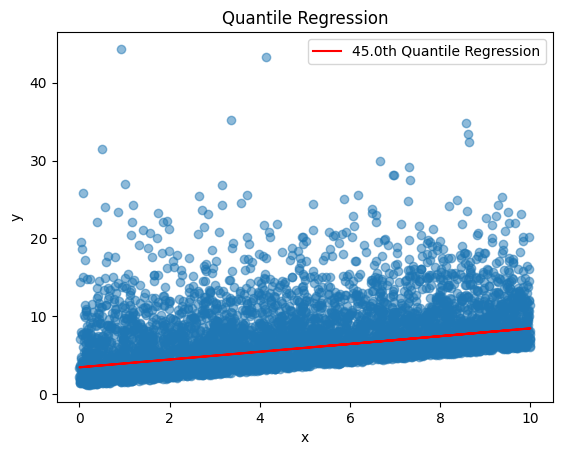

array([5.48813504, 7.15189366, 6.02763376, ..., 1.97388262, 3.9868722 ,
       9.58593103])

In [38]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

def generate_quantile_regression_data(quantile, dataset_size):
    np.random.seed(0)
    x = np.random.uniform(0, 10, dataset_size)
    errors = np.random.exponential(scale=4, size=dataset_size) - 2  # Асимметричные ошибки
    y = 3 + 0.5 * x + errors

    data = pd.DataFrame({'x': x, 'y': y})

    # Построение квантильной регрессии для заданного квантиля
    mod = smf.quantreg('y ~ x', data)
    res = mod.fit(q=quantile)

    # Визуализация результатов
    plt.scatter(x, y, alpha=0.5)
    plt.plot(x, res.params['Intercept'] + res.params['x'] * x, color='red', label=f'{quantile*100}th Quantile Regression')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Quantile Regression')
    plt.legend()
    plt.show()

    return x,y

# Пример использования функции
x,y=generate_quantile_regression_data(quantile=0.45, dataset_size=5000)
x

In [39]:
X = x
y = y

# Нормализация данных
scaler = StandardScaler()
X_scaled = X

# Разбиение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train = np.c_[np.ones(X_train.shape[0]), X_train]
X_test = np.c_[np.ones(X_test.shape[0]), X_test]


# Применение алгоритма
# Динамический квантиль
start_time = time.time()
dynamic_weights, final_quantile = gradient_descent(X_train, y_train, 0.5, dynamic_quantile=True)
dynamic_time = time.time() - start_time
dynamic_pred = X_test.dot(dynamic_weights)
dynamic_mse = mean_squared_error(y_test, dynamic_pred)

print(f"Dynamic Quantile Regression MSE: {dynamic_mse}")
print(f"Final dynamically adjusted quantile: {final_quantile}")
print(f"Time taken for Dynamic Quantile Regression: {dynamic_time} seconds")

# Фиксированные квантили
quantiles = np.arange(0.05, 1, 0.05)
fixed_results = []
start_time = time.time()
best_mse = float('inf')
best_quantile = None

for quantile in quantiles:
    weights, _ = gradient_descent(X_train, y_train, quantile)
    pred = X_test.dot(weights)
    mse = mean_squared_error(y_test, pred)
    fixed_results.append((quantile, mse))

    if mse < best_mse:
        best_mse = mse
        best_quantile = quantile

fixed_time = time.time() - start_time

print("Fixed Quantile Regression Results:")
for quantile, mse in fixed_results:
    print(f"Quantile {quantile:.2f} MSE: {mse}")

print(f"Best Quantile: {best_quantile}, Best MSE: {best_mse}")
print(f"Time taken for Fixed Quantile Regression: {fixed_time} seconds")




Dynamic Quantile Regression MSE: 25.307109347525245
Final dynamically adjusted quantile: 0.1423076923076923
Time taken for Dynamic Quantile Regression: 0.12307453155517578 seconds
Fixed Quantile Regression Results:
Quantile 0.05 MSE: 50.40614282373866
Quantile 0.10 MSE: 35.80261099839366
Quantile 0.15 MSE: 23.315605508258383
Quantile 0.20 MSE: 19.75968837303762
Quantile 0.25 MSE: 33.03617763639695
Quantile 0.30 MSE: 49.227770867891394
Quantile 0.35 MSE: 62.33469635785828
Quantile 0.40 MSE: 71.12521494734911
Quantile 0.45 MSE: 75.9987245995764
Quantile 0.50 MSE: 77.72934665289564
Quantile 0.55 MSE: 77.09800764860186
Quantile 0.60 MSE: 74.78006165986359
Quantile 0.65 MSE: 71.32636901068638
Quantile 0.70 MSE: 67.17195182190937
Quantile 0.75 MSE: 62.6632566672495
Quantile 0.80 MSE: 58.037834972913046
Quantile 0.85 MSE: 53.522717543618086
Quantile 0.90 MSE: 49.23437156921237
Quantile 0.95 MSE: 45.220931315297484
Best Quantile: 0.2, Best MSE: 19.75968837303762
Time taken for Fixed Quantile R